In [38]:
import numpy as np
import pandas as pd
import sys
import os
import pickle
import re
import textwrap
import corner
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join('..')))
from src.ultils import compile_data_from_folder
from sklearn.preprocessing import StandardScaler, LabelEncoder
import ldc.io.hdf5 as h5io
from ldc.lisa.noise import get_noise_model  

In [5]:
def extract_model_info(filename):
    """
    Extracts the model name and version from the filename.
    Example:
        'resolved_Model1_0_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5' -> 'Model 1.0'
        'resolved_Model1_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5' -> 'Model 1.1'
    """
    # Regular expression to capture 'Model' followed by a number, an underscore, and another number
    match = re.search(r'resolved_(Model)(\d+)_(\d+)_MW', filename)
    if match:
        model_prefix = match.group(1)      # 'Model'
        model_number = match.group(2)      # e.g., '1'
        model_version = match.group(3)     # e.g., '0', '1'
        # Format as 'Model 1.0', 'Model 1.1', etc.
        formatted_model = f"{model_prefix} {model_number}.{model_version}"
        return formatted_model
    else:
        return 'Unknown'
def process_h5_file(filepath):
    """
    Processes a single .h5 file and extracts the necessary parameters.
    Returns a pandas DataFrame with the extracted data and model information.
    """
    # Extract the model from the filename
    filename = os.path.basename(filepath)
    model = extract_model_info(filename)
    
    cats, units = h5io.load_array(filepath, 'cat')
    
    data = {
        'Name': cats['Name'],
        'Frequency': cats['Frequency'],
        'Amplitude': cats['Amplitude'],
        'FrequencyDerivative': cats['FrequencyDerivative'],
        'SNR': np.sqrt(cats['snr2']),
        'Eccentricity': cats['Eccentricity'],
        'Inclination': cats['Inclination'],
        'Polarization': cats['Polarization'],
        'EclipticLatitude': cats['EclipticLatitude'],
        'EclipticLongitude': cats['EclipticLongitude'],
        'InitialPhase': cats['InitialPhase'],
        'Model': model 
    }
    
    df = pd.DataFrame(data)
    
    return df
def compile_data_from_folder(folder_path):
    """
    Compiles data from all .h5 files in the specified folder into a single DataFrame.
    """
    all_data = []
    
    # List all .h5 files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.h5') and filename.startswith('resolved_'):
            filepath = os.path.join(folder_path, filename)
            try:
                df = process_h5_file(filepath)
                all_data.append(df)
                print(f"Processed file: {filename}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
    
    if all_data:
        # Concatenate all DataFrames
        combined_df = pd.concat(all_data, ignore_index=True)
        return combined_df
    else:
        print("No .h5 files found or no data extracted.")
        return pd.DataFrame()  # Return empty DataFrame if no data

In [7]:
def load_fim_data(folder_path):
    """
    Loads all pickle files from the specified folder and returns a dictionary
    with keys formatted as "Model X.Y" and values as the loaded data.

    Parameters:
      folder_path (str): Path to the folder containing the pickle files.

    Returns:
      dict: Dictionary where keys are formatted model strings and values are the loaded data.
    """
    loaded_data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.pkl') or filename.endswith('.pickle'):
            file_path = os.path.join(folder_path, filename)
            # Format the model string from the filename.
            formatted = re.sub(r".*?(Model)(\d+)_(\d+).*", r"\1 \2.\3", filename)
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
            loaded_data[formatted] = data
    return loaded_data

def generate_sample_dataframe(resolved_df, loaded_fim_data, n_samples_class0, n_samples_class1):
    """
    Generates samples using the FIM for each row in resolved_df and returns a DataFrame of all samples.
    
    Parameters:
      resolved_df (pd.DataFrame): DataFrame containing binary systems with required columns.
      loaded_fim_data (dict): Dictionary of FIM matrices keyed by model and binary name.
      n_samples_class0 (int): Number of samples to generate for Class 0.
      n_samples_class1 (int): Number of samples to generate for Class 1.
      
    Returns:
      final_df (pd.DataFrame): DataFrame containing the generated samples, along with the binary Name and Model.
    """
    
    def sample_from_FIM(row, loaded_fim_data, n_samples_class0, n_samples_class1):
        # Exclude rows where the model ends with ".0"
        if row['Model'].endswith('.0'):
            return None
        
        mean = np.array([
            row['Frequency_mHz'],            
            row['FrequencyDerivative_log10'],
            row['EclipticLatitude_sin'],    
            row['EclipticLongitude'],            
            row['Amplitude_log10'],           
            row['Inclination_cos'],         
            row['Polarization'],                 
            row['InitialPhase']                  
        ])
        
        model_key = row['Model']
        try:
            fim = loaded_fim_data[model_key][row['Name']]
        except KeyError:
            raise KeyError(f"FIM not found for model '{model_key}' and source '{row['Name']}'")
        
        cov = np.linalg.inv(fim)
        
        if row['Class'] == 'DWD':
            n_samples = n_samples_class0
        elif row['Class'] == 'NSWD':
            n_samples = n_samples_class1
        else:
            n_samples = n_samples_class0
        #cov = (cov + cov.T) / 2
        samples = np.random.multivariate_normal(mean, cov, size=n_samples)
        return samples
    

    samples_dict = {}
    for idx, row in resolved_df.iterrows():
        samples = sample_from_FIM(row, loaded_fim_data, n_samples_class0, n_samples_class1)
        if samples is None:
            continue  # Skip excluded rows

        key = (row['Name'], row['Model'])
        samples_dict[key] = {'samples': samples, 'Name': row['Name'], 'Model': row['Model']}
    
    parameter_names = ['Frequency_mHz', 'FrequencyDerivative_log10', 'EclipticLatitude_sin',
                       'EclipticLongitude', 'Amplitude_log10', 'Inclination_cos', 'Polarization', 'InitialPhase']
    
    df_list = []
    for data in samples_dict.values():
        samples = data['samples']
        name = data['Name']
        model = data['Model']
        df_temp = pd.DataFrame(samples, columns=parameter_names)
        df_temp['Name'] = name
        df_temp['Model'] = model
        df_list.append(df_temp)
    
    final_df = pd.concat(df_list, ignore_index=True)
    return final_df

In [6]:
resolved_folder_path = '/Users/irwin/Documents/GitHub/lisa-ml/data/resolved_binaries/'
resolved_df = compile_data_from_folder(resolved_folder_path)
resolved_df['Class'] = resolved_df['Name'].str.extract(r'MW_(DWD|NSWD)')
selected_features = ['Frequency', 'Amplitude', 'FrequencyDerivative', 'SNR', 'Eccentricity']

resolved_df = resolved_df.dropna(subset=selected_features + ['Class'])

# Encode labels: DWD=0, NSWD=1
label_encoder = LabelEncoder()
resolved_df['Class'] = label_encoder.fit_transform(resolved_df['Class'])
resolved_df['Frequency_mHz'] = resolved_df['Frequency'] * 1000
resolved_df['FrequencyDerivative_log10'] = np.log10(resolved_df['FrequencyDerivative'])
resolved_df['EclipticLatitude_sin'] = np.sin(resolved_df['EclipticLatitude'])
resolved_df['Amplitude_log10'] = np.log10(resolved_df['Amplitude'])
resolved_df['Inclination_cos'] = np.cos(resolved_df['Inclination'])

cols_to_remove = ['Frequency', 'FrequencyDerivative', 'EclipticLatitude', 'Amplitude', 'Inclination']
resolved_df.drop(columns=cols_to_remove, inplace=True)

Processed file: resolved_Model2_1_MW_DWDs_aa2CE_NSWDs_aa2CE_vkick.h5
Processed file: resolved_Model2_2_MW_DWDs_aa2CE_NSWDs_aa2CE_akick.h5
Processed file: resolved_Model3_1_MW_DWDs_agCE_NSWDs_agCE_vkick.h5
Processed file: resolved_Model3_0_MW_DWDs_agCE.h5
Processed file: resolved_Model1_1_MW_DWDs_aaCE_NSWDs_aaCE_vkick.h5
Processed file: resolved_Model1_0_MW_DWDs_aaCE.h5
Processed file: resolved_Model1_2_MW_DWDs_aaCE_NSWDs_aaCE_akick.h5
Processed file: resolved_Model2_4_MW_DWDs_aa2CE_NSWDs_aa2CE_bkick.h5
Processed file: resolved_Model1_4_MW_DWDs_aaCE_NSWDs_aaCE_bkick.h5
Processed file: resolved_Model2_3_MW_DWDs_aa2CE_NSWDs_aa2CE_hkick.h5
Processed file: resolved_Model1_3_MW_DWDs_aaCE_NSWDs_aaCE_hkick.h5


In [8]:
loaded_fim_data = load_fim_data("/Users/irwin/Documents/GitHub/lisa-ml/data/fims")

In [9]:
df_samples = generate_sample_dataframe(resolved_df, loaded_fim_data, 5, 5)

/var/folders/rm/5j_dp79x6xx6xmxlxxs9k4y80000gn/T/ipykernel_1424/708789417.py:68: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, size=n_samples)


In [12]:
df_samples[df_samples['Amplitude_log10']< -2000]

,Frequency_mHz,FrequencyDerivative_log10,EclipticLatitude_sin,EclipticLongitude,Amplitude_log10,Inclination_cos,Polarization,InitialPhase,Name,Model
12836,3.666402,-16.176235,-0.418206,-1.871900,-2219.312433,4930.189891,-1.820192e+04,-3.640792e+04,MW_DWD 1810341,Model 3.1
75113,2.291212,-15.651002,0.275657,-1.674382,-2414.677039,5511.376835,7.905364e+04,1.581098e+05,MW_NSWD_ecc1 9759,Model 3.1
78637,2.085382,-16.278759,-0.892306,2.917229,-2698.000630,6325.611747,3.913953e+04,7.827760e+04,MW_DWD 2530556,Model 3.1
89136,2.158196,-17.705732,-0.716295,-2.278283,-2096.515884,-4584.078813,-2.858848e+04,5.718844e+04,MW_DWD 11139403,Model 3.1
96635,2.404852,-17.229658,-0.090537,-1.677054,-5045.328839,-4863.388071,-6.088528e+05,1.217693e+06,MW_DWD 17493096,Model 3.1
96636,2.404850,-16.351857,-0.168561,-1.716914,-10200.098075,-25695.004973,1.369451e+05,-2.738726e+05,MW_DWD 17493096,Model 3.1
96637,2.404848,-16.538869,-0.164541,-1.689606,-2723.749957,-2610.753120,-3.278441e+05,6.556866e+05,MW_DWD 17493096,Model 3.1
96638,2.404846,-17.543922,-0.159779,-1.668615,-6442.048762,-15851.583581,5.561410e+04,-1.112137e+05,MW_DWD 17493096,Model 3.1
201005,1.542039,-18.681703,-0.617675,-2.001657,-6299.217315,14828.475090,4.756212e+04,9.511727e+04,MW_DWD 3743504,Model 1.1
201006,1.542037,-16.606045,-0.553805,-1.967487,-7662.962268,18624.362762,1.306429e+05,2.612771e+05,MW_DWD 3743504,Model 1.1


In [23]:
selected_features = [
    'Frequency_mHz',
    'FrequencyDerivative_log10',
    'EclipticLatitude_sin',
    'EclipticLongitude',
    'Amplitude_log10',
    'Inclination_cos',
    'Polarization',
    'InitialPhase'
    ]
mean = resolved_df[(resolved_df['Name'] == 'MW_DWD 17493096') & (resolved_df['Model'] == 'Model 3.1')][selected_features]

In [27]:
mean.to_numpy()

array([[  2.4048475 , -16.80996983,  -0.13592027,  -1.69904568,
        -22.91405138,  -0.99998444,   5.616135  ,   0.8858316 ]])

In [33]:
loaded_fim_data['Model 1.1']['parameter names']

['Frequency_mHz',
 'FrequencyDerivative_log10',
 'EclipticLatitude_sin',
 'EclipticLongitude',
 'Amplitude_log10',
 'Inclination_cos',
 'Polarization',
 'InitialPhase']

In [17]:
fim = loaded_fim_data['Model 3.1']['MW_DWD 17493096']
cov = np.linalg.inv(fim)

/var/folders/rm/5j_dp79x6xx6xmxlxxs9k4y80000gn/T/ipykernel_1424/110820698.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean.to_numpy()[0], cov, size=100000)


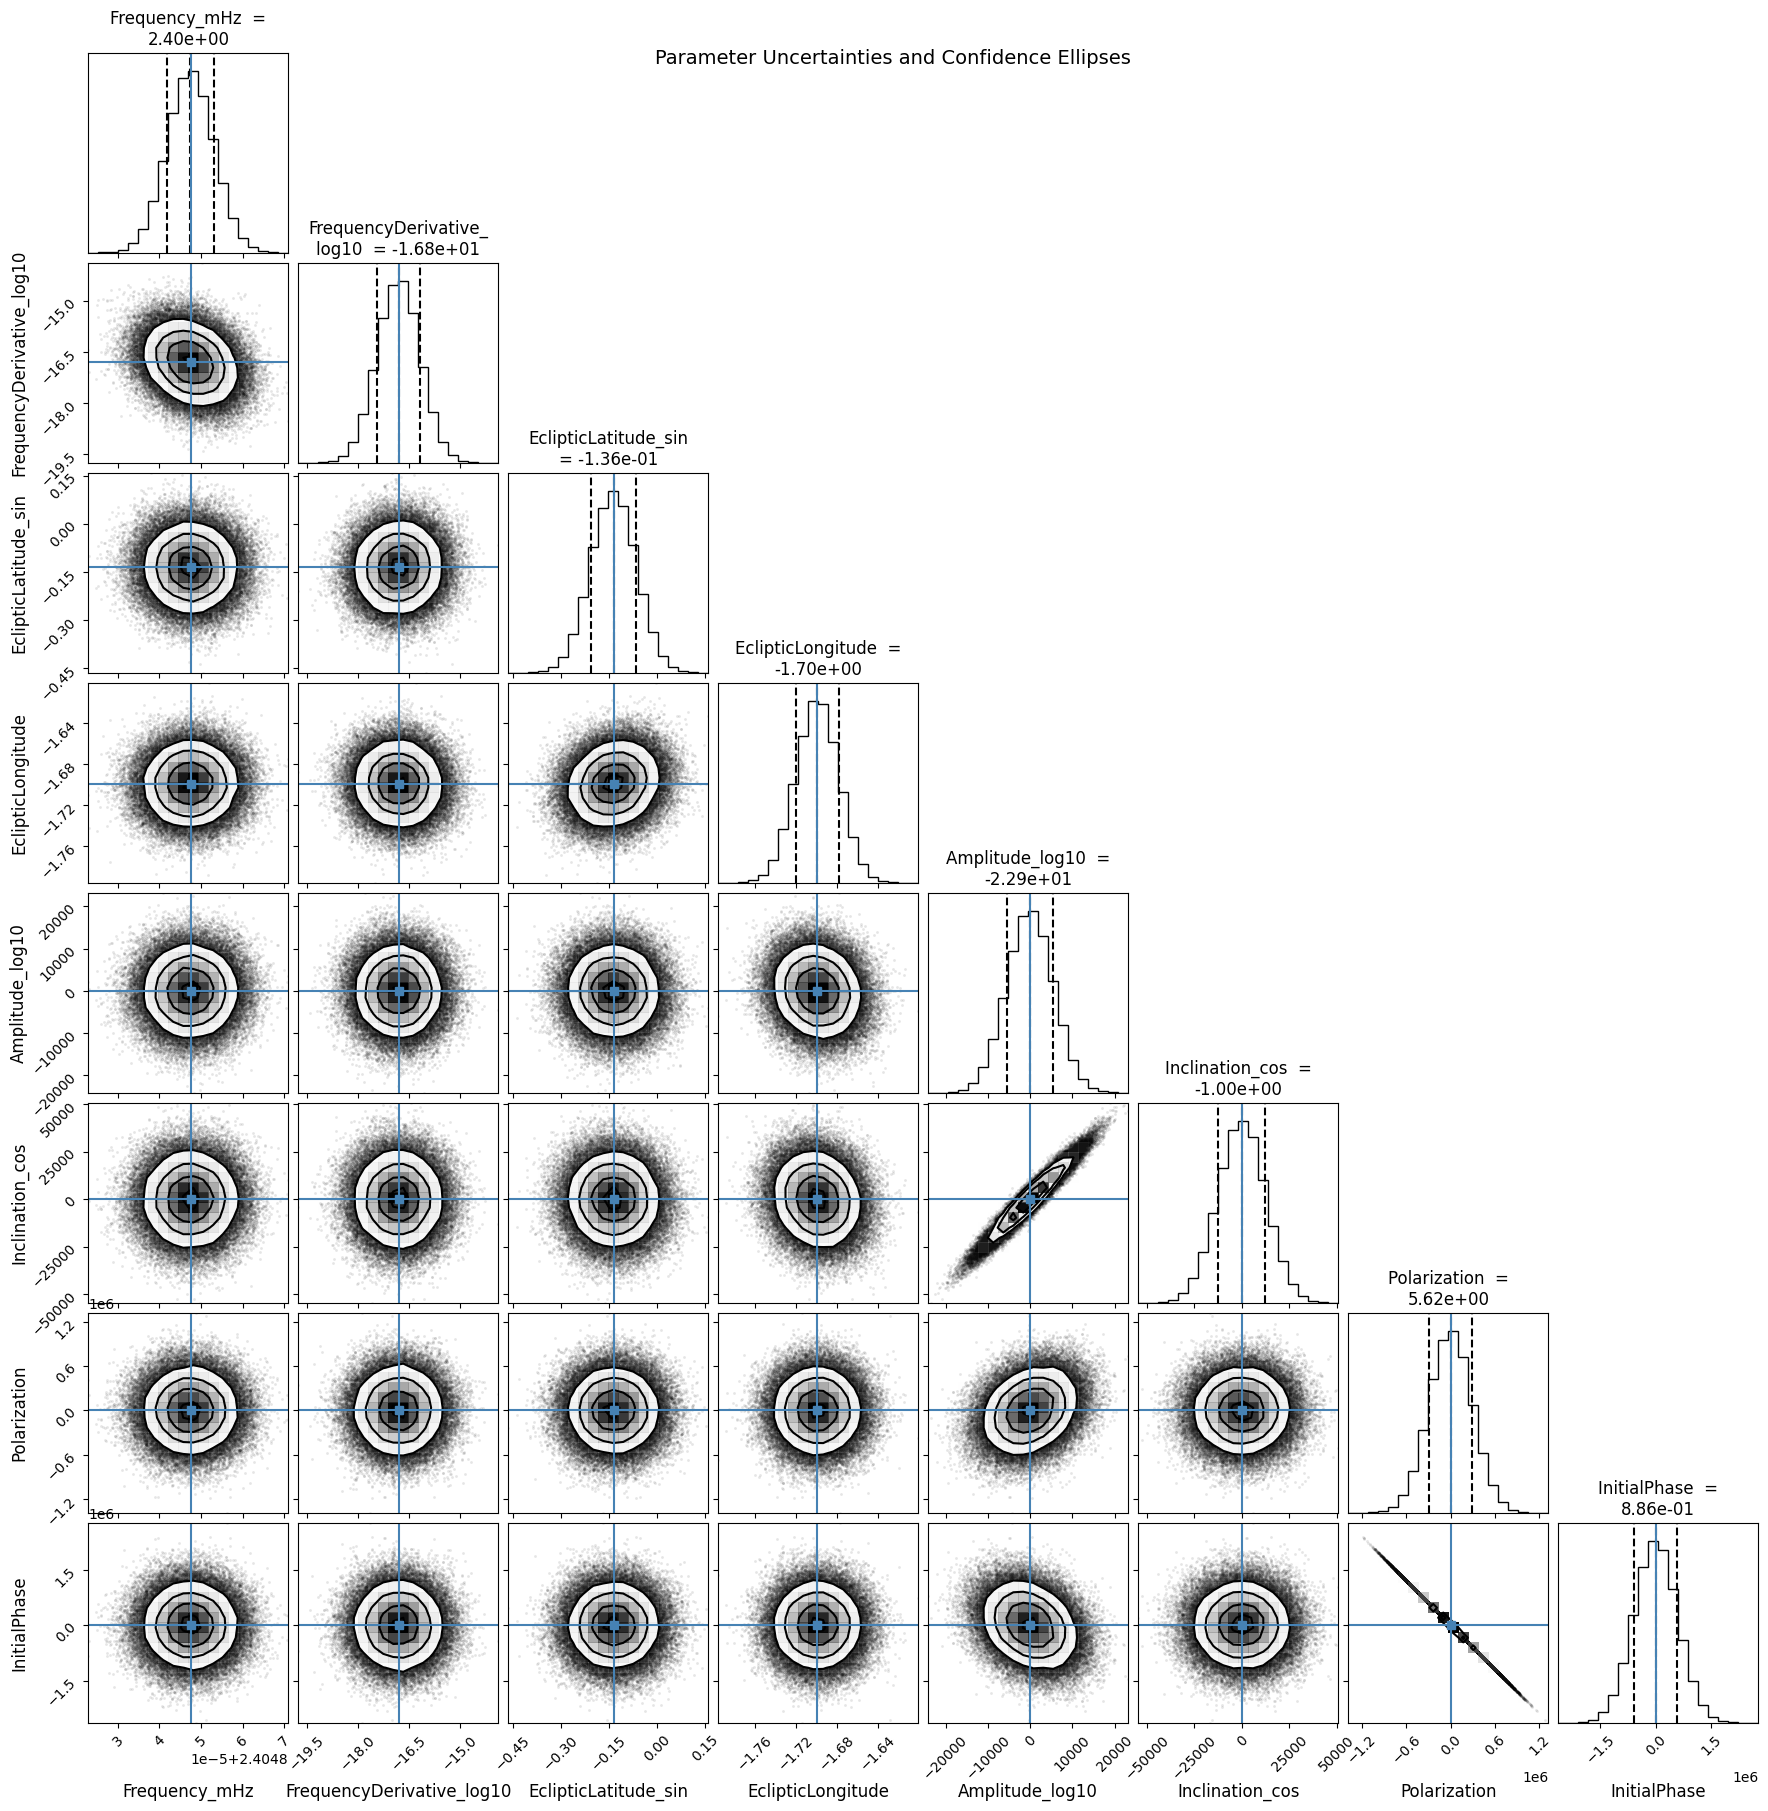

In [39]:
samples = np.random.multivariate_normal(mean.to_numpy()[0], cov, size=100000)
fig = corner.corner(
samples,
labels=selected_features,
quantiles=[0.16, 0.5, 0.84],
show_titles=False,
title_fmt=".2f",
label_kwargs={"fontsize": 12, "wrap": True},
truths=mean.to_numpy()[0],
title_kwargs={"fontsize": 10, "wrap": True}
)
for ax in fig.get_axes():
    plt.setp(ax.get_xticklabels(), fontsize=10)  
    plt.setp(ax.get_yticklabels(), fontsize=10) 
    
for ax in fig.get_axes():
    ax.xaxis.get_offset_text().set_fontsize(10)
    ax.yaxis.get_offset_text().set_fontsize(10)
axes = np.array(fig.axes).reshape(len(selected_features), len(selected_features))
for i, ax in enumerate(axes.diagonal()):
    # Custom wrapped title
    title_text = f"{selected_features[i]} \n= {mean.to_numpy()[0][i]:.2e}"
    wrapped_text = "\n".join(textwrap.wrap(title_text, width=20))  # Adjust width as needed
    ax.set_title(wrapped_text, fontsize=12)     
plt.suptitle(f"Parameter Uncertainties and Confidence Ellipses", fontsize=14)
plt.show()

,Name,SNR,Eccentricity,Polarization,EclipticLongitude,InitialPhase,Model,Class,Frequency_mHz,FrequencyDerivative_log10,EclipticLatitude_sin,Amplitude_log10,Inclination_cos
0,MW_DWD 0,40.929675,0.000000,0.188781,-1.796378,1.743567,Model 2.1,0,5.831488,-15.037016,-0.351313,-22.392716,0.130661
1,MW_DWD 305,12.663876,0.000000,5.567065,2.669358,0.614617,Model 2.1,0,1.032685,-17.988213,-0.048640,-22.131877,-0.567883
2,MW_DWD 336,7.494779,0.000000,5.029394,-1.943069,1.035197,Model 2.1,0,1.394106,-17.510344,-0.589556,-22.784182,0.922483
3,MW_DWD 343,12.629021,0.000000,0.959902,-1.823988,1.642656,Model 2.1,0,1.562902,-17.328345,-0.415794,-22.671332,0.937526
4,MW_DWD 345,9.684461,0.000000,6.137735,-1.674099,0.222782,Model 2.1,0,1.614743,-17.276382,-0.096953,-22.811105,0.914601
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168721,MW_NSWD_ecc1 36818,14.337639,0.858406,0.315960,-1.551163,3.953830,Model 1.3,1,1.844884,-16.934493,-0.130805,-22.787111,0.997029
168722,MW_NSWD_ecc1 46118,9.564295,0.615259,5.096369,-2.345533,2.725020,Model 1.3,1,2.232109,-16.511926,-0.464487,-23.014052,-0.807019
168723,MW_NSWD_ecc1 52477,9.630959,0.781611,1.463049,-1.767237,6.199689,Model 1.3,1,2.260619,-16.750075,-0.155333,-23.048656,-0.847065
168724,MW_NSWD_ecc1 52477,9.557340,0.781611,1.463049,-1.767237,6.199689,Model 1.3,1,2.363374,-16.730770,-0.155333,-23.083515,-0.847065
